In [1]:
gpu_info = !nvidia-smi
gpu_info = gpu_info[:10]
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Oct  7 18:11:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    20W /  70W |      0MiB / 15079MiB |      0%      Default |


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import torch
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm_notebook as tq

from torch.autograd import Variable
from torchvision.transforms import transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [4]:
base_path = "/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/"
sys.path.append(base_path)
# torch.manual_seed(123)

In [5]:
from src.data_utils import LoadDataset, SavePath
from src.config import TrainConfig

In [6]:
args = TrainConfig( base_path,              # project directory path
                    n_epochs = 200,         # number of epochs to train (default: 100)
                    batch_size = 128,       # input batch size for training (default: 128)
                    lr = 0.0002,            # learning rate (default: 0.0001)
                    dim_h = 128,            # hidden dimension (default: 128)')
                    n_z = 8,                # hidden dimension of z (default: 8)
                    LAMBDA = 10,            # regularization coef term (default: 10)
                    sigma = 1,              # variance of hidden dimension (default: 1)
                    n_channel = 1,          # input channels (default: 1)
                    img_size = 28 )         # image size

In [7]:
def unfreeze_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def freeze_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [8]:
def save_models(model_path, epoch_no, encoder, decoder, discriminator):
    print("Saving models")
    if encoder:
        torch.save(encoder.state_dict(), model_path + "/encoder_" + "%d.pth" % epoch_no)
    if decoder:
        torch.save(decoder.state_dict(), model_path + "/decoder_" + "%d.pth" % epoch_no)
    if discriminator:
        torch.save(discriminator.state_dict(), model_path + "/discriminator_" + "%d.pth" % epoch_no)

def save_lists(list_path, epoch_no, reconstr_loss):
    print("Saving list")
    if reconstr_loss:
        np.savetxt(list_path + '/reconstr_loss_' + '%d.txt'% epoch_no, reconstr_loss)

In [9]:
sp = SavePath(args, checkpoint_path="/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Tue-Sep-29-22-37-45-2020/")
# sp = SavePath(args)

/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Tue-Sep-29-22-37-45-2020/


In [10]:
cdl = LoadDataset(args, data='mnist')
train_loader = cdl.get_data_loader(train=True)
test_loader = cdl.get_data_loader(train=False)

In [20]:
# for step, (images, _) in enumerate(train_loader):
#     print(_[0])
#     images = images.cuda()
#     shape = images.size()
#     images = images.reshape([shape[0], shape[1], shape[2]*shape[3], 1])
#     print(images.shape)
#     complex_images = torch.cat((images, torch.zeros_like(images)), 3)
#     images_fft = complex_images.fft(signal_ndim=1, normalized=False)
#     # torch.fft()
#     images_ifft = images_fft.ifft(signal_ndim=1, normalized=False)
#     images_ifft = images_ifft.sum(3)
#     pixel = 150
#     # print(images_ifft.shape)
#     print(images[0][0][pixel], images_fft[0][0][pixel], images_ifft[0][0][pixel])
#     break

In [24]:
image_path, list_path, model_path = sp.get_save_paths()
disc_dict = torch.load(model_path + "/discriminator_{}.pth".format(400))

In [26]:
for layer, weight in disc_dict.items():
    print(layer, weight.shape)

main.0.weight torch.Size([512, 8])
main.0.bias torch.Size([512])
main.2.weight torch.Size([512, 512])
main.2.bias torch.Size([512])
main.4.weight torch.Size([512, 512])
main.4.bias torch.Size([512])
main.6.weight torch.Size([512, 512])
main.6.bias torch.Size([512])
main.8.weight torch.Size([1, 512])
main.8.bias torch.Size([1])


In [11]:
class Encoder(nn.Module):

    def __init__(self, args):
        super(Encoder, self).__init__()
        
        self.n_z = args.n_z
        self.dim_h = args.dim_h
        self.dim_input = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.dim_input, self.dim_h * 16),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 16, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 2, self.dim_h),
            nn.ReLU(True),
            nn.Linear(self.dim_h, self.n_z)
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [12]:
class Decoder(nn.Module):

    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_z = args.n_z
        self.dim_h = args.dim_h
        self.dim_output = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h),
            nn.ReLU(True),
            nn.Linear(self.dim_h, self.dim_h * 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 2, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 16),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 16, self.dim_output),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [13]:
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args.dim_h
        self.n_z = args.n_z

        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            # nn.Linear(self.dim_h * 4, self.dim_h * 4),
            # nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [14]:
encoder, decoder, discriminator = Encoder(args), Decoder(args), Discriminator(args)
criterion = nn.MSELoss()

encoder.train()
decoder.train()
discriminator.train()

# Optimizers
enc_optim = optim.Adam(encoder.parameters(), lr = args.lr)
dec_optim = optim.Adam(decoder.parameters(), lr = args.lr)
dis_optim = optim.Adam(discriminator.parameters(), lr = 0.5*args.lr)

In [15]:
if torch.cuda.is_available():
    encoder, decoder, discriminator = encoder.cuda(), decoder.cuda(), discriminator.cuda()

In [30]:
summary(discriminator, (1, 8))
summary(decoder, (1, 8))
summary(encoder, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]           4,608
              ReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 512]         262,656
              ReLU-4               [-1, 1, 512]               0
            Linear-5               [-1, 1, 512]         262,656
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 512]         262,656
              ReLU-8               [-1, 1, 512]               0
            Linear-9                 [-1, 1, 1]             513
          Sigmoid-10                 [-1, 1, 1]               0
Total params: 793,089
Trainable params: 793,089
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.03
Estimated T

In [31]:
one = torch.tensor(1)
mone = one * -1
if torch.cuda.is_available():
    one, mone = one.cuda(), mone.cuda()

In [55]:
checkpoint = 275

if checkpoint:
    _, list_path, model_path = sp.get_save_paths()

    encoder.load_state_dict(torch.load(
                    model_path + "/encoder_{}.pth".format(checkpoint)))
    decoder.load_state_dict(torch.load(
                    model_path + "/decoder_{}.pth".format(checkpoint)))
    discriminator.load_state_dict(torch.load(
            model_path + "/discriminator_{}.pth".format(checkpoint)))
    reconstr_loss_epoch = np.loadtxt(
        list_path + '/reconstr_loss_{}.txt'.format(checkpoint)).tolist()
else:
    reconstr_loss_epoch = []
reconstr_loss = []
disc_loss = []
d_real_val = []

In [33]:
image_path, list_path, model_path = sp.get_save_paths()

In [61]:
for epoch in range(checkpoint, checkpoint+args.n_epochs):
    for step, (images, _) in tq(enumerate(train_loader)):

        images = images.reshape([images.size()[0], 1, args.img_size**2])

        if torch.cuda.is_available():
            images = images.cuda()

        encoder.zero_grad()
        decoder.zero_grad()
        discriminator.zero_grad()

        # ======== Train Discriminator ======== #

        freeze_params(decoder)
        freeze_params(encoder)
        unfreeze_params(discriminator)

        z_fake = torch.randn(images.size()[0], args.n_z) * args.sigma

        if torch.cuda.is_available():
            z_fake = z_fake.cuda()

        d_fake = discriminator(z_fake)

        z_real = encoder(images)
        d_real = discriminator(z_real)

        # df = round(torch.true_divide((d_fake <= 0.5).sum(), d_fake.shape[0]).item(), 3)
        # dr = round(torch.true_divide((d_real > 0.5).sum(), d_real.shape[0]).item(), 3)
        # negate for gradient ascent
        d_loss = -(torch.log(d_fake.mean()) + torch.log((1 - d_real).mean()))

        disc_loss.append([d_fake.mean().item(), d_real.mean().item(), d_loss.item()])

        d_loss.backward()

        dis_optim.step()

        # ======== Train Generator ======== #

        unfreeze_params(decoder)
        unfreeze_params(encoder)
        freeze_params(discriminator)

        batch_size = images.size()[0]

        z_real = encoder(images)
        x_recon = decoder(z_real)
        d_real = discriminator(encoder(Variable(images.data)))

        d_real_val.append((torch.log(d_real)).mean().item())

        recon_loss = criterion(x_recon, images) # - args.LAMBDA * (torch.log(d_real)).mean()

        d_loss = -(args.LAMBDA * (torch.log(d_real)).mean())

        reconstr_loss.append(recon_loss.data.item())

        recon_loss.backward()
        d_loss.backward()

        enc_optim.step()
        dec_optim.step()
            

    if (epoch + 1) % 1 == 0:
        temp = np.mean(disc_loss, axis=0)
        print("Epoch: [%d/%d], Recon Loss: [%.4f], Reg loss: [%.4f], D_fake: [%.4f], D_real: [%.4f], D_loss: [%.4f]" %
                (epoch + 1, args.n_epochs, 
                 np.mean(reconstr_loss), np.mean(d_real_val), temp[0], temp[1], temp[2]))
        disc_loss.clear()
        d_real_val.clear()
    
    if (epoch + 1) % 1 == 0:

        reconstr_loss_epoch.append(np.mean(reconstr_loss))
        reconstr_loss.clear()

        batch_size = args.batch_size
        test_iter = iter(test_loader)
        test_data = next(test_iter)
        test_data = Variable(test_data[0]).reshape([batch_size, 1, args.img_size**2])
        # test_data = test_data

        z_real = encoder(test_data.cuda())
        reconst = decoder(z_real).cpu().view(batch_size, 1, 28, 28)
        sample = decoder(torch.randn_like(z_real)).cpu().view(batch_size, 1, 28, 28)

        image = torch.cat((test_data.view(batch_size, 1, 28, 28), 
                                reconst.data), axis=3)
        
        save_image(image, image_path +
                                '/inputs_reconstr_{}.png'.format(epoch+1))
        
        save_image(sample, image_path + 
                                '/sample_{}.png'.format(epoch+1))

        # save_image(test_data[0].view(batch_size, 1, 28, 28), image_path + '/wae_gan_input.png')
        # save_image(reconst.data, image_path + '/wae_gan_images_%d.png' % (epoch + 1))
    
    if (epoch + 1) % 25 == 0:
        save_models(model_path, epoch+1, encoder, decoder, discriminator)
        save_lists(list_path, epoch+1, reconstr_loss_epoch)
    

RuntimeError: ignored

In [148]:
test_iter = iter(test_loader)
test_data, test_labels = next(test_iter)
test_data = test_data.to(device='cuda')
test_data = test_data.reshape([test_data.size()[0], 1, args.img_size**2])
test_labels = test_labels.numpy()
z_test = encoder(test_data)
z_test = z_test.squeeze().detach().cpu().numpy()
z_test.shape

(128, 8)

In [149]:
train_iter = iter(train_loader)
train_data, train_labels = next(train_iter)
train_data = train_data.to(device='cuda')
train_data = train_data.reshape([train_data.size()[0], 1, args.img_size**2])

In [150]:
train_labels = train_labels.numpy()
z_train = encoder(train_data)
z_train = z_train.squeeze().detach().cpu().numpy()
z_train.shape

(128, 8)

In [151]:
tsne = TSNE()
pca = PCA()

In [152]:
z_train_tsne = tsne.fit_transform(z_train)
z_train_pca = pca.fit_transform(z_train)
z_test_tsne = tsne.fit_transform(z_test)
z_test_pca = pca.fit_transform(z_test)

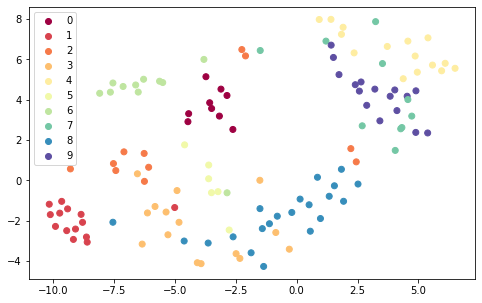

In [153]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_train_tsne[:,0], z_train_tsne[:,1], c=train_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(train_labels)))
plt.show()

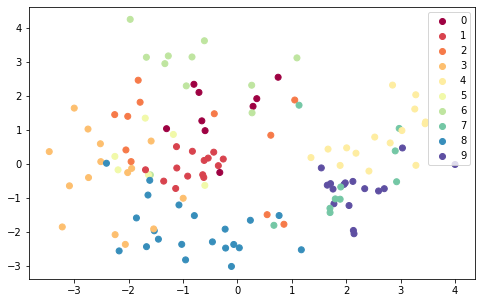

In [154]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_train_pca[:,0], z_train_pca[:,1], c=train_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(train_labels)))
plt.show()

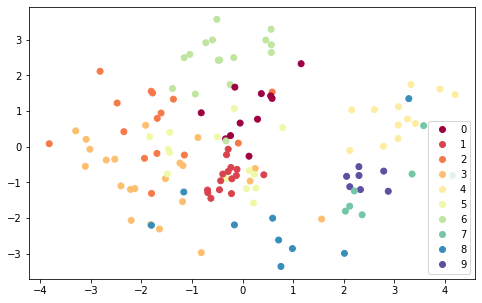

In [155]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_test_pca[:,0], z_test_pca[:,1], c=test_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(test_labels)))
plt.show()

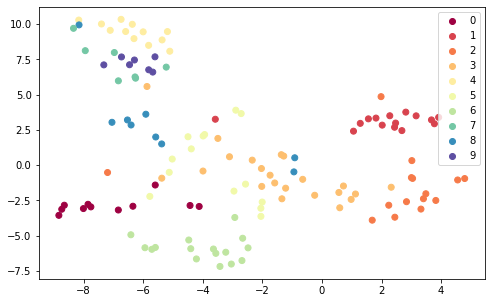

In [157]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_test_tsne[:,0], z_test_tsne[:,1], c=test_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(test_labels)))
plt.show()

(128, 8)

In [93]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns

In [47]:
z_l[0]

array([-2.6060193 ,  0.24894208], dtype=float32)

In [ ]:
print('[%s]' % ', '.join(map(str, np.mean(disc_loss, axis=0))))

[0.5, 0.5]


In [ ]:
class Encoder(nn.Module):

    def __init__(self, args):
        super(Encoder, self).__init__()
        
        self.n_z = args.n_z
        self.channels = args.n_channel
        self.dim_input = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Conv1d(self.channels, self.channels * 512, kernel_size=5, stride=3),
            nn.LeakyReLU(0.1, True),
            nn.Conv1d(self.channels * 512, self.channels * 256, kernel_size=4, stride=3),
            nn.LeakyReLU(0.1, True),
            nn.Conv1d(self.channels * 256, self.channels * 128, kernel_size=4, stride=3),
            nn.LeakyReLU(0.1, True),
            nn.Conv1d(self.channels * 128, self.channels, kernel_size=4, stride=2),
            nn.LeakyReLU(0.1, True),
            nn.Linear(13, self.n_z)
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
class Decoder(nn.Module):

    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_z = args.n_z
        self.channels = args.n_channel
        self.dim_output = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.n_z, 196),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose1d(self.channels, self.channels * 512, kernel_size=6, stride=2, padding=2),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose1d(self.channels*512, self.channels * 256, kernel_size=6, stride=1, padding=2),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose1d(self.channels * 256, self.channels * 1, kernel_size=4, stride=2, padding=2),
            # nn.LeakyReLU(0.1, True),
            # nn.ConvTranspose1d(self.channels * 256, self.channels * 128, kernel_size=4, stride=3),
            # nn.LeakyReLU(0.1, True),
            # nn.ConvTranspose1d(self.channels * 128, self.channels * 1, kernel_size=4, stride=3),
            # nn.LeakyReLU(0.1, True),
            # nn.ConvTranspose1d(self.channels * 32, self.channels, kernel_size=4, stride=2),
            # nn.Linear(715, self.dim_output),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.main(x)
        return x